In [2]:
'''
This is for all things data analysis.
'''

'\nThis is for all things data analysis.\n'

In [16]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import folium
import numpy as np

/Users/noahlokocz/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [4]:
'''
Open data.
'''
# All measurement data
df_measurement_data = pd.read_csv('data/combined_measurement_data.csv')
# All the selected probes including their type and location
df_selected_probes = pd.read_csv('data/coordinates_continents_selected_probes.csv')
# Selected probes joined with measured data
df_probes_measurement_joined = df_selected_probes.merge(df_measurement_data, how='inner', left_on='id', right_on='prb_id')

type_x
cellular    235.249187
ethernet    233.042539
starlink    141.502486
wifi         11.215364
Name: rtt, dtype: float64


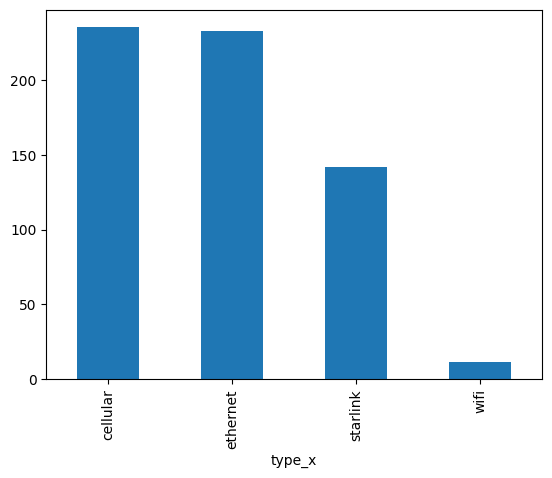

In [18]:
'''
Plot the average rtt for the different access technologies.
'''
df_probes_measurement_joined.groupby('type_x')['rtt'].mean().plot(kind='bar')

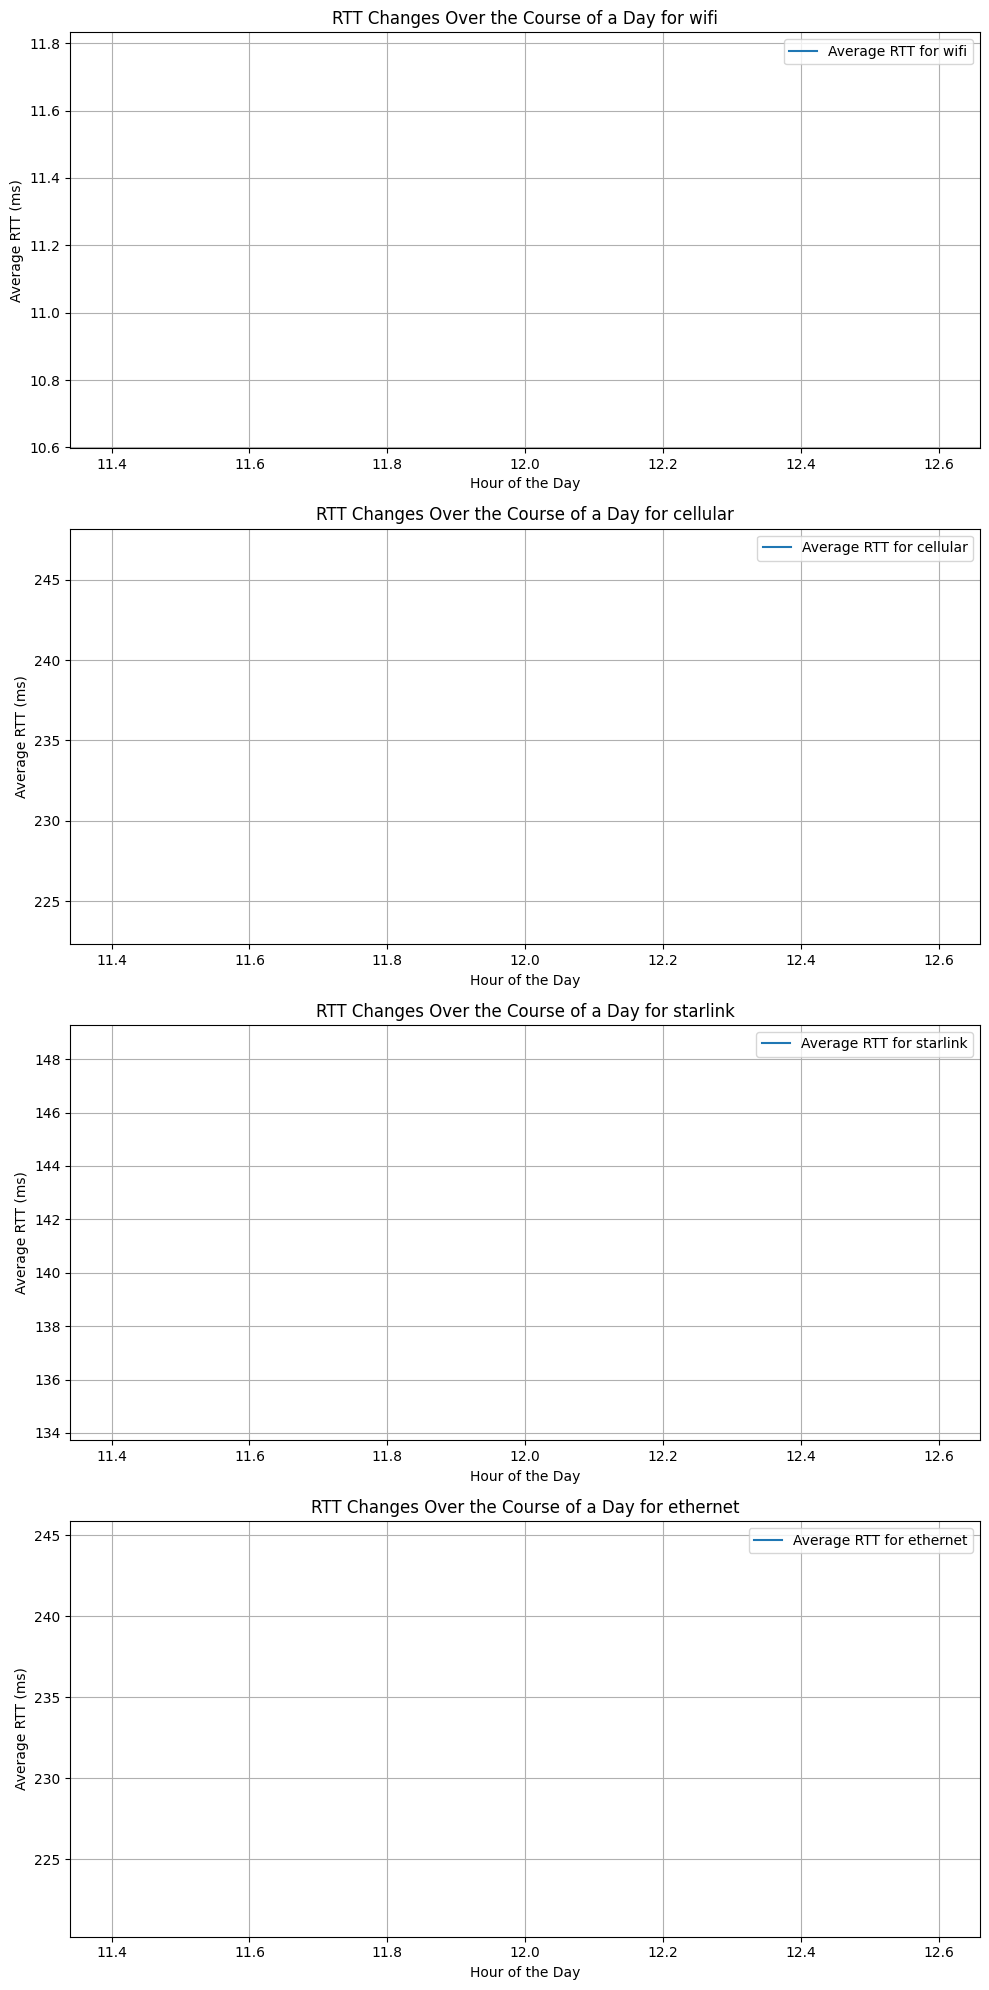

In [22]:
'''
Plot the rtt over the course of a day for each access technology.
'''
# Convert the timestamp to datetime and append to df
df_probes_measurement_joined['datetime'] = pd.to_datetime(df_probes_measurement_joined['timestamp'], unit='s')

# Extracting the hour of the day
df_probes_measurement_joined['hour'] = df_probes_measurement_joined['datetime'].dt.hour

technologies = df_probes_measurement_joined['type_x'].unique()

# Plot the RTT changes for each technology
fig, axs = plt.subplots(len(technologies), 1, figsize=(10, 5*len(technologies)))

for i, tech in enumerate(technologies):
    # Filter the DataFrame by technology
    df_tech = df_probes_measurement_joined[df_probes_measurement_joined['type_x'] == tech]
    
    # Group by hour and calculate the average RTT
    avg_rtt_by_hour = df_tech.groupby('hour')['rtt'].mean()
    
    axs[i].plot(avg_rtt_by_hour.index, avg_rtt_by_hour.values, label=f'Average RTT for {tech}')
    axs[i].set_title(f'RTT Changes Over the Course of a Day for {tech}')
    axs[i].set_xlabel('Hour of the Day')
    axs[i].set_ylabel('Average RTT (ms)')
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()


In [14]:
'''
Get all the probes which are in the probe to datacenter mapping but did not appear in the measured data.
'''

# Left join
non_matching_probes = df_selected_probes.merge(df_probes_measurement_joined[['prb_id']], how='left', left_on='id', right_on='prb_id', indicator=True).loc[lambda x: x['_merge'] == 'left_only']

# Drop the columns that came from df_probes_measurement_joined and the _merge column
print("Probes without measurements:")
useless_probes = non_matching_probes.drop(columns=['prb_id', '_merge'])
print(useless_probes)

print("Number of probes not actually measuring by type:")
print(useless_probes.groupby(['type'])['type'].count())


Probes without measurements:
     Unnamed: 0       id      type  latitude  longitude      continent  \
0             0  1006833      wifi   10.1385    76.4585           Asia   
1             1  1000559      wifi   42.6915    23.3395         Europe   
2             2    29049      wifi   30.3615   -91.0005  North America   
3             3    52844      wifi   37.7795   140.4495           Asia   
4             4    24628      wifi  -23.6685   -46.7415  South America   
..          ...      ...       ...       ...        ...            ...   
244         144    61780  starlink   43.1575   -70.6485  North America   
245         145    61435  starlink   46.7395   -79.8115  North America   
246         146    23127  starlink   43.2505  -124.3915  North America   
247         147    62553  starlink   36.1185   -79.1605  North America   
248         148    61899  starlink   39.2115   -86.8685  North America   

    country code  
0             IN  
1             BG  
2             US  
3     

In [17]:
'''
Create a map of all the nodes which did not perform any measurements in order to possibly identify any problems.
'''

# Center map
m = folium.Map(location=[20,0], zoom_start=5)

# Add markers for all probes that are not performing measurements
for index, row in non_matching_probes.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=row['id'],
        icon=folium.Icon(color='blue', icon='map-marker')
    ).add_to(m)
    
# Save map
m.save('maps/useless_probes.html')